In [1]:
from train import get_grnti1_2_BERT_dataframes, get_grnti1_BERT_dataframes, prepair_datasets,\
prepair_model, prepair_compute_metrics, save_parameters, CustomTrainer, test_predictons,\
prepair_test_dataset, get_grnti1_BERT_dataframes
from peft import PeftConfig, PeftModel

from prediction import prepair_data_level2
from prediction import prepair_model as prepair_model_test
from prediction import prepair_dataset, make_predictions
from transformers import TrainingArguments
import os
import random
import numpy as np
import torch

In [2]:
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

### Train level 1 correct

In [3]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [5]:
base_name = "results_5/"
number_of_delteted_values = 11
minimal_number_of_elements_RGNTI2 = 1
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level1/"

In [6]:
epoch= 8
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 1/"

Удаление элементов второго уровня, количство которых меньше 1
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружение

100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9907599844636907


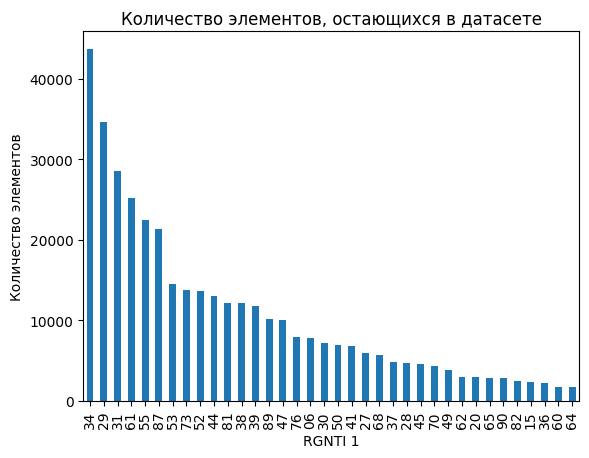

In [7]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save)

In [21]:
n_classes

36

In [8]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes, 
                                                        level = '',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([2.8698, 0.8063, 2.8038, 1.4198, 0.3597, 2.7281, 0.6670, 0.5559, 0.6174,
        1.0258, 0.2824, 1.6508, 1.1662, 4.6529, 0.5866, 1.3501, 2.7373, 1.0197,
        0.6825, 4.7243, 0.1849, 0.5923, 1.1935, 1.1275, 3.4616, 1.7276, 3.5452,
        0.6665, 0.2440, 0.3205, 1.8386, 3.2657, 0.3774, 0.7982, 1.7576, 2.0721],
       dtype=torch.float64)
Подготовка тренировочных данных:


Map:   0%|          | 0/232662 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/58132 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [9]:
n_classes

36

In [10]:
model = prepair_model(n_classes=n_classes, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [11]:
model.to("cuda");

In [12]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [13]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes)


In [14]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,
    dataloader_num_workers  = 4

    )

In [15]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [15]:
# train_dataset = train_dataset.remove_columns("text")
# validation_dataset = train_dataset.remove_columns(["text"])

In [16]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [17]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 232662
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 58132
 }))

In [18]:
trainer.train()

  0%|          | 0/232664 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6409, 'grad_norm': 0.733366847038269, 'learning_rate': 4.9980657972783624e-05, 'epoch': 0.0}
{'loss': 0.1424, 'grad_norm': 0.5432657599449158, 'learning_rate': 4.9959166831432086e-05, 'epoch': 0.01}
{'loss': 0.1392, 'grad_norm': 0.3310622572898865, 'learning_rate': 4.993767569008055e-05, 'epoch': 0.01}
{'loss': 0.135, 'grad_norm': 0.3173268139362335, 'learning_rate': 4.9916184548729015e-05, 'epoch': 0.01}
{'loss': 0.1349, 'grad_norm': 0.3139289915561676, 'learning_rate': 4.9894693407377477e-05, 'epoch': 0.02}
{'loss': 0.1248, 'grad_norm': 0.29151636362075806, 'learning_rate': 4.9873202266025945e-05, 'epoch': 0.02}
{'loss': 0.1358, 'grad_norm': 0.21374638378620148, 'learning_rate': 4.985171112467441e-05, 'epoch': 0.02}
{'loss': 0.1247, 'grad_norm': 0.3895171582698822, 'learning_rate': 4.983021998332288e-05, 'epoch': 0.03}
{'loss': 0.1339, 'grad_norm': 0.40065503120422363, 'learning_rate': 4.980872884197134e-05, 'epoch': 0.03}
{'loss': 0.1337, 'grad_norm': 0.4376426339149475, 

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.05600685998797417, 'eval_accuracy_micro_0.5': 0.976485013961792, 'eval_accuracy_macro_0.5': 0.976485013961792, 'eval_accuracy_weighted_0.5': 0.9620198011398315, 'eval_f1_micro_0.5': 0.6078023314476013, 'eval_f1_macro_0.5': 0.5237987041473389, 'eval_f1_weighted_0.5': 0.5657841563224792, 'eval_f1_micro_0.6': 0.5495141744613647, 'eval_f1_macro_0.6': 0.45243167877197266, 'eval_f1_weighted_0.6': 0.4923853278160095, 'eval_f1_micro_0.7': 0.46480047702789307, 'eval_f1_macro_0.7': 0.36883461475372314, 'eval_f1_weighted_0.7': 0.40769100189208984, 'eval_f1_micro_0.8': 0.3209470510482788, 'eval_f1_macro_0.8': 0.09775763750076294, 'eval_f1_weighted_0.8': 0.11246836930513382, 'eval_f1_micro_0.9': 0.12671782076358795, 'eval_aucroc_micro': 0.8593754172325134, 'eval_aucroc_macro': 0.8363762497901917, 'eval_aucroc_weighted': 0.8533414602279663, 'eval_runtime': 1994.3782, 'eval_samples_per_second': 29.148, 'eval_steps_per_second': 3.644, 'epoch': 1.0}
{'loss': 0.0601, 'grad_norm': 0.46840

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.04598516970872879, 'eval_accuracy_micro_0.5': 0.9798222780227661, 'eval_accuracy_macro_0.5': 0.9798222780227661, 'eval_accuracy_weighted_0.5': 0.9670683145523071, 'eval_f1_micro_0.5': 0.6818363070487976, 'eval_f1_macro_0.5': 0.6323137283325195, 'eval_f1_weighted_0.5': 0.6563282012939453, 'eval_f1_micro_0.6': 0.645669162273407, 'eval_f1_macro_0.6': 0.582875669002533, 'eval_f1_weighted_0.6': 0.606844961643219, 'eval_f1_micro_0.7': 0.588180422782898, 'eval_f1_macro_0.7': 0.514491856098175, 'eval_f1_weighted_0.7': 0.53690105676651, 'eval_f1_micro_0.8': 0.4988791346549988, 'eval_f1_macro_0.8': 0.2751307785511017, 'eval_f1_weighted_0.8': 0.2896997332572937, 'eval_f1_micro_0.9': 0.3419117331504822, 'eval_aucroc_micro': 0.8784512877464294, 'eval_aucroc_macro': 0.8637183904647827, 'eval_aucroc_weighted': 0.8737152814865112, 'eval_runtime': 2007.1678, 'eval_samples_per_second': 28.962, 'eval_steps_per_second': 3.621, 'epoch': 2.0}
{'loss': 0.0543, 'grad_norm': 0.0586908720433712,

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.04164758697152138, 'eval_accuracy_micro_0.5': 0.9812586307525635, 'eval_accuracy_macro_0.5': 0.9812586307525635, 'eval_accuracy_weighted_0.5': 0.9692254662513733, 'eval_f1_micro_0.5': 0.7131982445716858, 'eval_f1_macro_0.5': 0.6806359887123108, 'eval_f1_weighted_0.5': 0.6994292736053467, 'eval_f1_micro_0.6': 0.686564564704895, 'eval_f1_macro_0.6': 0.6442689895629883, 'eval_f1_weighted_0.6': 0.6645625233650208, 'eval_f1_micro_0.7': 0.6391134858131409, 'eval_f1_macro_0.7': 0.5899279713630676, 'eval_f1_weighted_0.7': 0.6069968938827515, 'eval_f1_micro_0.8': 0.5531378984451294, 'eval_f1_macro_0.8': 0.3564908802509308, 'eval_f1_weighted_0.8': 0.3438565135002136, 'eval_f1_micro_0.9': 0.39381638169288635, 'eval_aucroc_micro': 0.8927895426750183, 'eval_aucroc_macro': 0.8818662166595459, 'eval_aucroc_weighted': 0.8881924748420715, 'eval_runtime': 2007.9653, 'eval_samples_per_second': 28.951, 'eval_steps_per_second': 3.619, 'epoch': 3.0}
{'loss': 0.0499, 'grad_norm': 0.2239900380

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.03899683803319931, 'eval_accuracy_micro_0.5': 0.982240617275238, 'eval_accuracy_macro_0.5': 0.9822405576705933, 'eval_accuracy_weighted_0.5': 0.970640242099762, 'eval_f1_micro_0.5': 0.729957103729248, 'eval_f1_macro_0.5': 0.7047665119171143, 'eval_f1_weighted_0.5': 0.7180867791175842, 'eval_f1_micro_0.6': 0.7050315141677856, 'eval_f1_macro_0.6': 0.6707038283348083, 'eval_f1_weighted_0.6': 0.6855694651603699, 'eval_f1_micro_0.7': 0.6616116762161255, 'eval_f1_macro_0.7': 0.6195817589759827, 'eval_f1_weighted_0.7': 0.6326414346694946, 'eval_f1_micro_0.8': 0.5860152244567871, 'eval_f1_macro_0.8': 0.40908488631248474, 'eval_f1_weighted_0.8': 0.39173272252082825, 'eval_f1_micro_0.9': 0.4362528622150421, 'eval_aucroc_micro': 0.897736668586731, 'eval_aucroc_macro': 0.8880607485771179, 'eval_aucroc_weighted': 0.8936863541603088, 'eval_runtime': 2145.0647, 'eval_samples_per_second': 27.1, 'eval_steps_per_second': 3.388, 'epoch': 4.0}
{'loss': 0.0385, 'grad_norm': 0.17513734102249

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.03764447942376137, 'eval_accuracy_micro_0.5': 0.9828603863716125, 'eval_accuracy_macro_0.5': 0.9828604459762573, 'eval_accuracy_weighted_0.5': 0.971631646156311, 'eval_f1_micro_0.5': 0.745842456817627, 'eval_f1_macro_0.5': 0.7295314073562622, 'eval_f1_weighted_0.5': 0.7361676692962646, 'eval_f1_micro_0.6': 0.7285481691360474, 'eval_f1_macro_0.6': 0.7057878971099854, 'eval_f1_weighted_0.6': 0.7123809456825256, 'eval_f1_micro_0.7': 0.6946464776992798, 'eval_f1_macro_0.7': 0.6614851355552673, 'eval_f1_weighted_0.7': 0.6688758730888367, 'eval_f1_micro_0.8': 0.6355012655258179, 'eval_f1_macro_0.8': 0.4797120988368988, 'eval_f1_weighted_0.8': 0.46760082244873047, 'eval_f1_micro_0.9': 0.5114779472351074, 'eval_aucroc_micro': 0.9062063694000244, 'eval_aucroc_macro': 0.9011973142623901, 'eval_aucroc_weighted': 0.902497410774231, 'eval_runtime': 2140.9052, 'eval_samples_per_second': 27.153, 'eval_steps_per_second': 3.394, 'epoch': 5.0}
{'loss': 0.0343, 'grad_norm': 0.112077012658

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.03663526847958565, 'eval_accuracy_micro_0.5': 0.9832698702812195, 'eval_accuracy_macro_0.5': 0.9832698702812195, 'eval_accuracy_weighted_0.5': 0.9723479747772217, 'eval_f1_micro_0.5': 0.7533532381057739, 'eval_f1_macro_0.5': 0.7364463806152344, 'eval_f1_weighted_0.5': 0.7453702092170715, 'eval_f1_micro_0.6': 0.7355892658233643, 'eval_f1_macro_0.6': 0.7113877534866333, 'eval_f1_weighted_0.6': 0.7216265201568604, 'eval_f1_micro_0.7': 0.7044228315353394, 'eval_f1_macro_0.7': 0.6703859567642212, 'eval_f1_weighted_0.7': 0.682243824005127, 'eval_f1_micro_0.8': 0.6487809419631958, 'eval_f1_macro_0.8': 0.4929107129573822, 'eval_f1_weighted_0.8': 0.48298683762550354, 'eval_f1_micro_0.9': 0.5246407985687256, 'eval_aucroc_micro': 0.910312831401825, 'eval_aucroc_macro': 0.9035404920578003, 'eval_aucroc_weighted': 0.9064745903015137, 'eval_runtime': 2312.4643, 'eval_samples_per_second': 25.139, 'eval_steps_per_second': 3.143, 'epoch': 6.0}
{'loss': 0.0388, 'grad_norm': 0.52048462629

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.03598980978131294, 'eval_accuracy_micro_0.5': 0.983503520488739, 'eval_accuracy_macro_0.5': 0.9835034608840942, 'eval_accuracy_weighted_0.5': 0.972788393497467, 'eval_f1_micro_0.5': 0.7570735812187195, 'eval_f1_macro_0.5': 0.742099404335022, 'eval_f1_weighted_0.5': 0.7488794922828674, 'eval_f1_micro_0.6': 0.7410232424736023, 'eval_f1_macro_0.6': 0.7208302617073059, 'eval_f1_weighted_0.6': 0.727164626121521, 'eval_f1_micro_0.7': 0.7105450630187988, 'eval_f1_macro_0.7': 0.6813111305236816, 'eval_f1_weighted_0.7': 0.6885271072387695, 'eval_f1_micro_0.8': 0.6566224098205566, 'eval_f1_macro_0.8': 0.5118038058280945, 'eval_f1_weighted_0.8': 0.49728015065193176, 'eval_f1_micro_0.9': 0.5390498042106628, 'eval_aucroc_micro': 0.9119118452072144, 'eval_aucroc_macro': 0.9067419767379761, 'eval_aucroc_weighted': 0.9083424806594849, 'eval_runtime': 2091.721, 'eval_samples_per_second': 27.791, 'eval_steps_per_second': 3.474, 'epoch': 7.0}
{'loss': 0.0364, 'grad_norm': 0.10379233956336

  0%|          | 0/7267 [00:00<?, ?it/s]

{'eval_loss': 0.03570238873362541, 'eval_accuracy_micro_0.5': 0.983637809753418, 'eval_accuracy_macro_0.5': 0.983637809753418, 'eval_accuracy_weighted_0.5': 0.9729700088500977, 'eval_f1_micro_0.5': 0.7591949105262756, 'eval_f1_macro_0.5': 0.7441495656967163, 'eval_f1_weighted_0.5': 0.7511130571365356, 'eval_f1_micro_0.6': 0.7426037192344666, 'eval_f1_macro_0.6': 0.7220563292503357, 'eval_f1_weighted_0.6': 0.7288102507591248, 'eval_f1_micro_0.7': 0.7133274078369141, 'eval_f1_macro_0.7': 0.683270275592804, 'eval_f1_weighted_0.7': 0.6913082003593445, 'eval_f1_micro_0.8': 0.6600103378295898, 'eval_f1_macro_0.8': 0.5119954943656921, 'eval_f1_weighted_0.8': 0.500533401966095, 'eval_f1_micro_0.9': 0.5419660806655884, 'eval_aucroc_micro': 0.912045419216156, 'eval_aucroc_macro': 0.9064035415649414, 'eval_aucroc_weighted': 0.9084251523017883, 'eval_runtime': 2002.832, 'eval_samples_per_second': 29.025, 'eval_steps_per_second': 3.628, 'epoch': 8.0}
{'train_runtime': 104699.9927, 'train_samples_pe

TrainOutput(global_step=232664, training_loss=0.04921626353495035, metrics={'train_runtime': 104699.9927, 'train_samples_per_second': 17.777, 'train_steps_per_second': 2.222, 'total_flos': 2.0572459623394243e+17, 'train_loss': 0.04921626353495035, 'epoch': 8.0})

In [ ]:
# trainer.model.save_pretrained("bert_peft_level1")

In [ ]:
# trainer.save_model("bert_peft_level1_v2")

### Тest level 1

In [24]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [25]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [ ]:
# torch.save("trainer_predictions_level1.pt")

In [37]:
# with open("trainer_predictions_level1.npy", 'wb') as f:
#     np.save(f, predict_res)


    
with open("trainer_predictions_level1.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [ ]:
predict_res

In [32]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [29]:
label_test = np.vstack(df_test["target_coded"])

100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


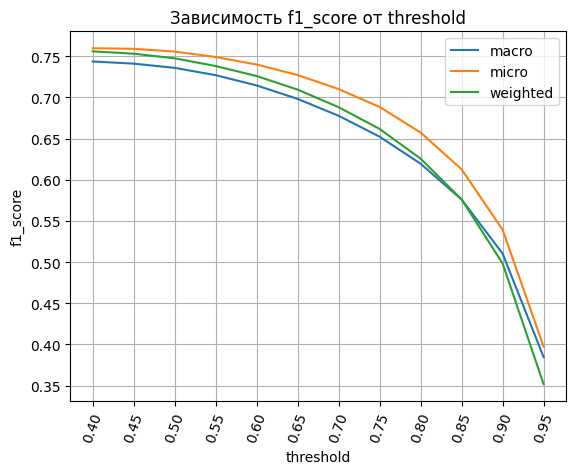

In [38]:
test_predictons(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 36)

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import torch
from collections import Counter
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecision, MultilabelRecall
from datasets import Dataset
from TrainSettings import TrainSettings

from ignite.metrics import ClassificationReport
from ignite.engine.engine import Engine

from ignite.metrics.precision import Precision
from ignite.metrics.recall import Recall
from ignite.metrics.metrics_lambda import MetricsLambda


In [144]:
def test_predictons_v2(preds, test_dataset_labels, dir_name, n_classes):
    treshold_list = [0.4 + 0.025 * x for x in range(0, 24, 2)]
    f1_score_macro_list = []
    f1_score_micro_list = []
    f1_score_weighted_list = []


    precision_macro_list = []
    precision_micro_list = []
    precision_weighted_list = []

    recall_macro_list = []
    recall_micro_list = []
    recall_weighted_list = []
    
    best_treshold = None
    best_metrics  = dict()
    best_some_f1 = 0
    preds = torch.tensor(preds)

    for treshold in tqdm(treshold_list):
        multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        multilabel_precision_macro = MultilabelPrecision(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        multilabel_recall_macro = MultilabelRecall(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        
        f1_score_macro_list.append(multilabel_f1_score_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        precision_macro_list.append(multilabel_precision_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_macro_list.append(multilabel_recall_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        ####
        multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro', threshold=treshold)
        multilabel_precision_micro = MultilabelPrecision(num_labels=n_classes, average='micro', 
                                                      threshold=treshold)
        multilabel_recall_micro = MultilabelRecall(num_labels=n_classes, average='micro', 
                                                      threshold=treshold)
        
        f1_score_micro_list.append(multilabel_f1_score_micro(preds, #torch.tensor(test_predictions_level1_2)
                                                            torch.tensor(test_dataset_labels)))
        
        precision_micro_list.append(multilabel_precision_micro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_micro_list.append(multilabel_recall_micro(preds, 
                                                            torch.tensor(test_dataset_labels)))

        ####

        multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted',
                                                        threshold=treshold)
        multilabel_precision_weighted  = MultilabelPrecision(num_labels=n_classes, average='weighted', 
                                                      threshold=treshold)
        multilabel_recall_weighted = MultilabelRecall(num_labels=n_classes, average='weighted', 
                                                      threshold=treshold)
        

        f1_score_weighted_list.append(multilabel_f1_score_weighted(preds,#torch.tensor(test_predictions_level1_2), 
                                                            torch.tensor(test_dataset_labels)))
        precision_weighted_list.append(multilabel_precision_weighted(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_weighted_list.append(multilabel_recall_weighted(preds, 
                                                            torch.tensor(test_dataset_labels)))
        ####


        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]

        if sum_f1 > best_some_f1:
            best_some_f1 = sum_f1
            best_treshold = treshold
            best_metrics["best_treshold"] = best_treshold

            best_metrics["f1_macro"] = f1_score_macro_list[-1].detach().item()
            best_metrics["f1_micro"] = f1_score_micro_list[-1].detach().item()
            best_metrics["f1_weighted"] = f1_score_weighted_list[-1].detach().item()

            best_metrics["precision_macro"] = precision_macro_list[-1].detach().item()
            best_metrics["precision_micro"] = precision_micro_list[-1].detach().item()
            best_metrics["precision_weighted"] = precision_weighted_list[-1].detach().item()

            best_metrics["recall_macro"] = recall_macro_list[-1].detach().item()
            best_metrics["recall_micro"] = recall_micro_list[-1].detach().item()
            best_metrics["recall_weighted"] = recall_weighted_list[-1].detach().item()


    multilabel_f1_score_none = MultilabelF1Score(num_labels=n_classes, average='none',
                                                    threshold=best_treshold)
    multilabel_f1_score_none_res = multilabel_f1_score_none(preds, torch.tensor(test_dataset_labels))

    with open('my_grnti1_int.json', "r") as code_file:
        grnti_mapping_dict_true_numbers = json.load(code_file) # Загружаем файл с кодами 
    grnti_mapping_dict_true_numbers_reverse = {y: x for x, y in 
                                               grnti_mapping_dict_true_numbers.items()}
    

    df_rubrics = pd.DataFrame({"№":[grnti_mapping_dict_true_numbers_reverse[key]
                                    for key in range(n_classes)], 
                                    "F1":torch.round(multilabel_f1_score_none_res, decimals=2)})
    df_rubrics.sort_values(by=['№'], 
                           ascending=True).to_csv(dir_name + "threshold_№_F1_sorted_by_№.csv",
                                                   index=False) 

    df_rubrics.sort_values(by=['F1'], 
                           ascending=False).to_csv(dir_name + "threshold_№_F1_sorted_by_F1.csv", 
                                                   index=False) 
    
    preds_best_treshold = torch.sum(preds >= best_treshold, axis = 1)
    
    preds_best_treshold_no_zeros = preds_best_treshold[preds_best_treshold > 0.99]


    print("Cтатистика количества пркдсказываемых классов при заданном threshold:")
    print("Среднее число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.sum(preds_best_treshold_no_zeros)/preds_best_treshold_no_zeros.shape[0])
    print("Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.min(preds_best_treshold_no_zeros))
    print("Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.max(preds_best_treshold_no_zeros))
    print("Доля статей без предсказанного класса:", 
          1 - preds_best_treshold_no_zeros.shape[0]/ preds_best_treshold.shape[0])
    plt.figure()

    plt.plot(treshold_list, f1_score_macro_list, label = "macro")
    plt.plot(treshold_list, f1_score_micro_list, label = "micro")
    plt.plot(treshold_list, f1_score_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость f1_score от threshold")
    plt.xlabel("threshold")
    plt.ylabel("f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость f1_score от threshold.png",
                    bbox_inches='tight')
    plt.close()
    plt.figure()


    plt.figure()
    plt.plot(treshold_list, precision_macro_list, label = "macro")
    plt.plot(treshold_list, precision_micro_list, label = "micro")
    plt.plot(treshold_list, precision_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость precision от threshold")
    plt.xlabel("threshold")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость precision от threshold.png",
                    bbox_inches='tight')
    plt.close()

    plt.figure()
    print("recall_micro_list threshold:", recall_micro_list)
    print("recall_macro_list threshold:", recall_macro_list)
    print("recall_wighted_list threshold:", recall_weighted_list)
    plt.plot(treshold_list, recall_macro_list, label = "macro")
    plt.plot(treshold_list, recall_micro_list, label = "micro")
    plt.plot(treshold_list, recall_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость recall от threshold")
    plt.xlabel("threshold")
    plt.ylabel("recall")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость recall от threshold.png",
                    bbox_inches='tight')
    plt.close()


    plt.figure()
    plt.plot(treshold_list, [torch.sum(torch.sum(preds >= treshold, axis = 1) < 0.1) / preds.shape[0] for 
                             treshold in tqdm(treshold_list)])
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость f1_score от threshold")
    plt.xlabel("threshold")
    plt.ylabel("Доля элементов с непредсказанным классом ")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость доли элементов с непредсказанным классом от threshold.png",
                    bbox_inches='tight')
    plt.close()
    with open(dir_name + "best_metrics_threshold.json", "w") as outfile:
        json.dump(best_metrics, outfile)

    ###Часть с 1-м, 2-м, 3-м
    top_k_list = list(range(1, 4))
    f1_score_macro_list = []
    f1_score_micro_list = []
    f1_score_weighted_list = []

    precision_macro_list = []
    precision_micro_list = []
    precision_weighted_list = []

    recall_macro_list = []
    recall_micro_list = []
    recall_weighted_list = []


    best_top_k = None
    best_metrics  = dict()
    best_some_f1 = 0
    test_dataset_labels = torch.tensor(test_dataset_labels, dtype=float)

    for top_k in tqdm(top_k_list):
        pred_for_top_k = torch.zeros(preds.shape, dtype=float)  
        labels_for_top_k = torch.zeros(preds.shape, dtype=float)  

        top_indeces = torch.topk(preds, top_k).indices

        preds_range = torch.arange(pred_for_top_k.size(0)).unsqueeze(1)

        pred_for_top_k[preds_range, top_indeces] = 1.

        labels_for_top_k[preds_range, top_indeces] = test_dataset_labels[preds_range, top_indeces]
        ###
        multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro')

        multilabel_precision_macro = MultilabelPrecision(num_labels=n_classes, average='macro')
        multilabel_recall_macro = MultilabelRecall(num_labels=n_classes, average='macro')
        
        f1_score_macro_list.append(multilabel_f1_score_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        precision_macro_list.append(multilabel_precision_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        recall_macro_list.append(multilabel_recall_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))

        ##
        multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro')

        multilabel_precision_micro = MultilabelPrecision(num_labels=n_classes, average='micro')
        multilabel_recall_micro = MultilabelRecall(num_labels=n_classes, average='micro')
        

        f1_score_micro_list.append(multilabel_f1_score_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        
        precision_micro_list.append(multilabel_precision_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        recall_micro_list.append(multilabel_recall_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))

        ##
        multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted')
        multilabel_precision_weighted  = MultilabelPrecision(num_labels=n_classes, average='weighted')
        multilabel_recall_weighted = MultilabelRecall(num_labels=n_classes, average='weighted')
        

        
        f1_score_weighted_list.append(multilabel_f1_score_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))
        precision_weighted_list.append(multilabel_precision_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))
        recall_weighted_list.append(multilabel_recall_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))

        ##
        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]
        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]

        if sum_f1 > best_some_f1:
            best_some_f1 = sum_f1
            best_top_k = top_k
            best_metrics["best_top_k"] = best_top_k

            best_metrics["f1_macro"] = f1_score_macro_list[-1].detach().item()
            best_metrics["f1_micro"] = f1_score_micro_list[-1].detach().item()
            best_metrics["f1_weighted"] = f1_score_weighted_list[-1].detach().item()

            best_metrics["precision_macro"] = precision_macro_list[-1].detach().item()
            best_metrics["precision_micro"] = precision_micro_list[-1].detach().item()
            best_metrics["precision_weighted"] = precision_weighted_list[-1].detach().item()

            best_metrics["recall_macro"] = recall_macro_list[-1].detach().item()
            best_metrics["recall_micro"] = recall_micro_list[-1].detach().item()
            best_metrics["recall_weighted"] = recall_weighted_list[-1].detach().item()

    pred_for_top_k = torch.zeros(preds.shape, dtype=float)  
    labels_for_top_k = torch.zeros(preds.shape,  dtype=float)  

    top_indeces = torch.topk(preds, best_top_k).indices
    preds_range = torch.arange(pred_for_top_k.size(0)).unsqueeze(1)


    pred_for_top_k[preds_range, top_indeces] = 1.
    labels_for_top_k[preds_range, top_indeces] = test_dataset_labels[preds_range, top_indeces]

    multilabel_f1_score_none = MultilabelF1Score(num_labels=n_classes, average='none')
    multilabel_f1_score_none_res = multilabel_f1_score_none(pred_for_top_k, labels_for_top_k)

    with open('my_grnti1_int.json', "r") as code_file:
        grnti_mapping_dict_true_numbers = json.load(code_file) # Загружаем файл с кодами 
    grnti_mapping_dict_true_numbers_reverse = {y: x for x, y in 
                                               grnti_mapping_dict_true_numbers.items()}
    

    df_rubrics = pd.DataFrame({"№":[grnti_mapping_dict_true_numbers_reverse[key]
                                    for key in range(n_classes)], 
                                    "F1":torch.round(multilabel_f1_score_none_res, decimals=2)})
    df_rubrics.sort_values(by=['№'], 
                           ascending=True).to_csv(dir_name + "top_k_№_F1_sorted_by_№.csv",
                                                   index=False) 

    df_rubrics.sort_values(by=['F1'], 
                           ascending=False).to_csv(dir_name + "top_k_№_F1_sorted_by_F1.csv", 
                                                   index=False) 
    
    preds_best_treshold = torch.sum(preds > 0., axis = 1)
    
    preds_best_treshold_no_zeros = preds_best_treshold[preds_best_treshold > 0.99]


    print("Cтатистика количества пркдсказываемых классов при не заданном threshold:")
    print("Среднее число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.sum(preds_best_treshold_no_zeros)/preds_best_treshold_no_zeros.shape[0])
    print("Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.min(preds_best_treshold_no_zeros))
    print("Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.max(preds_best_treshold_no_zeros))
    print("Доля статей без предсказанного класса:", 
          1 - preds_best_treshold_no_zeros.shape[0]/ preds_best_treshold.shape[0])
    
    plt.figure()
    plt.plot(top_k_list, f1_score_macro_list, label = "macro")
    plt.plot(top_k_list, f1_score_micro_list, label = "micro")
    plt.plot(top_k_list, f1_score_weighted_list, label = "weighted")

    print("f1_top_k_macro", np.round(f1_score_macro_list, decimals=2))
    print("f1_top_k_maicro", np.round(f1_score_micro_list, decimals=2))
    print("f1_top_k_weighted", np.round(f1_score_weighted_list, decimals=2))

    plt.xticks(top_k_list)
    plt.title("Зависимость f1_score от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость f1_score от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    plt.close()


    plt.figure()
    plt.plot(top_k_list, precision_macro_list, label = "macro")
    plt.plot(top_k_list, precision_micro_list, label = "micro")
    plt.plot(top_k_list, precision_weighted_list, label = "weighted")


    print("precision_top_k_macro", np.round(precision_macro_list, decimals=2))
    print("precision_top_k_maicro", np.round(precision_micro_list, decimals=2))
    print("precision_top_k_weighted", np.round(precision_weighted_list, decimals=2))
    
    plt.xticks(top_k_list)
    plt.title("Зависимость precision от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость precision от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    plt.close()


    print("recall_top_k_macro:", torch.stack(recall_macro_list) )
    print("recall_top_k_micro:", torch.stack(recall_micro_list))
    print("recall_top_k_weighted:", torch.stack(recall_weighted_list))

    plt.figure()
    plt.plot(top_k_list, torch.stack(recall_macro_list).to(int), label = "macro")
    plt.plot(top_k_list, torch.stack(recall_micro_list).to(int), label = "micro")
    plt.plot(top_k_list, torch.stack(recall_weighted_list).to(int), label = "weighted")
    plt.xticks(top_k_list)
    plt.title("Зависимость recall от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("recall")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость recall от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    # plt.close()

    with open(dir_name + "best_metrics_top_k.json", "w") as outfile:
        json.dump(best_metrics, outfile)

    def eval_step(engine, batch):
        return batch

    default_evaluator = Engine(eval_step)
    metric = ClassificationReport(output_dict=True, is_multilabel=True)
    weighted_metric_precision = Precision(average='weighted', is_multilabel=True)
    weighted_metric_recall= Recall(average='weighted', is_multilabel=True)

    preds = (preds >= 0.5).int() # torch.tensor(
    input = torch.tensor(test_dataset_labels).int()

    precision = Precision(average=False, is_multilabel=True)
    recall = Recall(average=False, is_multilabel=True)
    F1 = precision * recall * 2 / (precision + recall + 1e-20)
    freq = torch.tensor([sum(input[:, i]) for i in range(input.shape[1])])#.tolist()
    # weights_per_class = input.shape[0] / (torch.tensor([el if el > 0 else 1 for el in freq])* input.shape[1])
    F1_wieghted = MetricsLambda(lambda t: torch.sum(t * freq).item() / input.shape[0], F1) # 

    metric.attach(default_evaluator, "cr")
    weighted_metric_precision.attach(default_evaluator, "weighted precision")
    weighted_metric_recall.attach(default_evaluator, "weighted recall")
    F1_wieghted.attach(default_evaluator, "weighted F1")



    state = default_evaluator.run([[preds, input]])
    result = state.metrics['cr']
    result['weighted precision'] = state.metrics['weighted precision']

    result['weighted recall'] = state.metrics['weighted recall']
    result['weighted F1'] = state.metrics['weighted F1']

    with open(dir_name + "test_results.json", "w") as outfile:
        json.dump(result, outfile)


100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.3470)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(6)
Доля статей без предсказанного класса: 0.0465811785802398
recall_micro_list threshold: [tensor(0.7579), tensor(0.7343), tensor(0.7101), tensor(0.6838), tensor(0.6566), tensor(0.6268), tensor(0.5935), tensor(0.5569), tensor(0.5119), tensor(0.4552), tensor(0.3758), tensor(0.2495)]
recall_macro_list threshold: [tensor(0.7470), tensor(0.7248), tensor(0.7023), tensor(0.6775), tensor(0.6512), tensor(0.6230), tensor(0.5922), tensor(0.5585), tensor(0.5180), tensor(0.4683), tensor(0.4001), tensor(0.2870)]
recall_wighted_list threshold: [tensor(0.7579), tensor(0.7343), tensor(0.7101), tensor(0.6838), tensor(0.6566), te

100%|██████████| 12/12 [00:00<00:00, 60.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Cтатистика количества пркдсказываемых классов при не заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(36.)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(36)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(36)
Доля статей без предсказанного класса: 0.0
f1_top_k_macro [0.89 0.71 0.59]
f1_top_k_maicro [0.91 0.7  0.56]
f1_top_k_weighted [0.91 0.72 0.59]
precision_top_k_macro [0.81 0.56 0.43]
precision_top_k_maicro [0.83 0.54 0.39]
precision_top_k_weighted [0.84 0.57 0.43]
recall_top_k_macro: tensor([1., 1., 1.])
recall_top_k_micro: tensor([1., 1., 1.])
recall_top_k_weighted: tensor([1.0000, 1.0000, 1.0000])


C:\Users\victo\AppData\Local\Temp\ipykernel_7504\1841997680.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(test_dataset_labels).int()


<Figure size 640x480 with 0 Axes>

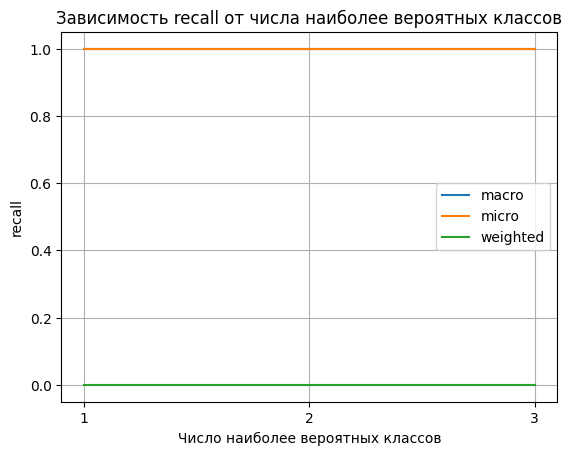

In [145]:
test_predictons_v2(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 36)

In [ ]:
# model = prepair_model_test(n_classes=36, lora_model_path = "bert_peft_level1")

### Train level 2 no labels correct

In [3]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [4]:
base_name = "results_5/"
number_of_delteted_values = 0
minimal_number_of_elements_RGNTI2 = 300
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level2_no_label/"

In [5]:
epoch= 8
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 2 no labels/"

Удаление элементов второго уровня, количство которых меньше 300
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружен

100%|██████████| 47/47 [00:29<00:00,  1.60it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9528220888159016


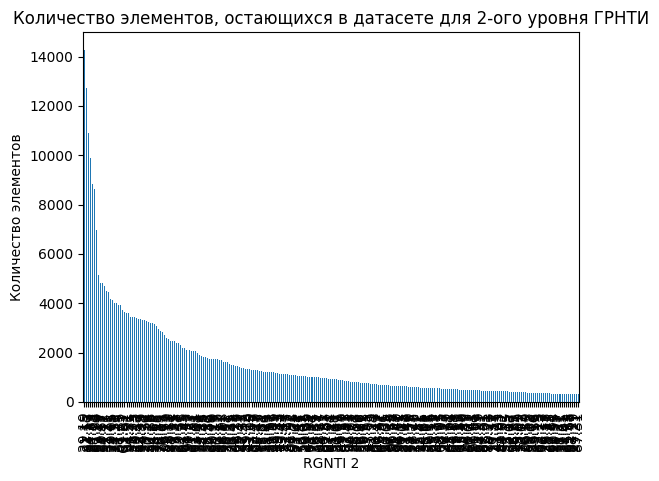

In [6]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_2_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder = "grnti_dicts_level2/")

In [7]:
df.shape

(279659, 13)

In [8]:
df_test.shape

(166183, 13)

In [9]:
n_classes, n_classes2

(47, 246)

In [10]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes2, 
                                                        level = '2',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([0.3324, 0.3050, 1.0957, 1.0359, 1.6289, 0.9368, 0.6091, 1.0129, 0.8051,
        1.0997, 0.9416, 0.4420, 2.2994, 0.6026, 0.3403, 0.5159, 0.6951, 2.6470,
        0.8494, 3.0454, 1.1965, 3.6569, 3.1184, 2.4879, 0.6715, 1.6677, 2.5795,
        0.5499, 1.0763, 2.0101, 2.9092, 1.5381, 0.1151, 1.7578, 2.5722, 0.1291,
        1.8321, 0.9995, 0.1317, 1.5645, 0.3132, 2.1127, 0.9802, 0.8174, 0.3629,
        0.9263, 1.9089, 2.7181, 1.1037, 1.5076, 1.4161, 2.0012, 2.7262, 2.7262,
        0.3832, 2.3348, 2.8367, 1.1719, 1.4710, 1.9752, 1.1934, 1.2076, 0.8656,
        0.6532, 0.3139, 0.1045, 1.6202, 1.8583, 1.9752, 1.4408, 1.7784, 1.1159,
        1.1325, 3.4622, 3.5991, 3.1950, 0.2844, 0.3359, 0.3512, 2.3590, 1.6348,
        2.6703, 0.4615, 1.4976, 1.5355, 0.2724, 0.7789, 2.3590, 0.8486, 0.3538,
        1.1439, 2.5016, 0.8781, 0.7464, 0.3536, 1.3734, 2.4478, 0.2879, 0.5738,
        1.0254, 2.1836, 0.3379, 1.2612, 0.7776, 1.4927, 0.2423, 0.9226, 0.9397,
        0.5495,

Map:   0%|          | 0/223999 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/55660 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [11]:
len(train_dataset['label'][0])

246

In [12]:
len(class_weights)

246

In [13]:
model = prepair_model(n_classes=n_classes2, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [14]:
model.to("cuda");

In [15]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [16]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes2)


In [17]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,#True,
    dataloader_num_workers  = 4

    )

In [18]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [19]:
# train_dataset = train_dataset.remove_columns("text")
# validation_dataset = train_dataset.remove_columns(["text"])

In [20]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [21]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 223999
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 55660
 }))

In [22]:
trainer.train()

  0%|          | 0/224000 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6725, 'grad_norm': 0.3940541744232178, 'learning_rate': 4.998013304165365e-05, 'epoch': 0.0}
{'loss': 0.0898, 'grad_norm': 0.11462166160345078, 'learning_rate': 4.995781061654539e-05, 'epoch': 0.01}
{'loss': 0.0387, 'grad_norm': 0.07039444148540497, 'learning_rate': 4.993548819143712e-05, 'epoch': 0.01}
{'loss': 0.0318, 'grad_norm': 0.06759679317474365, 'learning_rate': 4.9913165766328854e-05, 'epoch': 0.01}
{'loss': 0.0295, 'grad_norm': 0.07503867894411087, 'learning_rate': 4.989084334122059e-05, 'epoch': 0.02}
{'loss': 0.0285, 'grad_norm': 0.06111472100019455, 'learning_rate': 4.9868520916112326e-05, 'epoch': 0.02}
{'loss': 0.0266, 'grad_norm': 0.05699392408132553, 'learning_rate': 4.9846198491004066e-05, 'epoch': 0.03}
{'loss': 0.0269, 'grad_norm': 0.06709986180067062, 'learning_rate': 4.9823876065895806e-05, 'epoch': 0.03}
{'loss': 0.0276, 'grad_norm': 0.05494314059615135, 'learning_rate': 4.980155364078753e-05, 'epoch': 0.03}
{'loss': 0.0268, 'grad_norm': 0.056058276444

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.02060520090162754, 'eval_accuracy_micro_0.5': 0.9944756627082825, 'eval_accuracy_macro_0.5': 0.9944757223129272, 'eval_accuracy_weighted_0.5': 0.9863096475601196, 'eval_f1_micro_0.5': 0.019368639215826988, 'eval_f1_macro_0.5': 0.0034295564983040094, 'eval_f1_weighted_0.5': 0.014995203353464603, 'eval_f1_micro_0.6': 0.0022268504835665226, 'eval_f1_macro_0.6': 0.0005796899786219001, 'eval_f1_weighted_0.6': 0.0021378351375460625, 'eval_f1_micro_0.7': 0.00013115786714479327, 'eval_f1_macro_0.7': 3.803948129643686e-05, 'eval_f1_weighted_0.7': 0.0001305079204030335, 'eval_f1_micro_0.8': 0.0, 'eval_f1_macro_0.8': 0.0, 'eval_f1_weighted_0.8': 0.0, 'eval_f1_micro_0.9': 0.0, 'eval_aucroc_micro': 0.5406813621520996, 'eval_aucroc_macro': 0.5089731216430664, 'eval_aucroc_weighted': 0.5395442247390747, 'eval_runtime': 1742.6429, 'eval_samples_per_second': 31.94, 'eval_steps_per_second': 3.993, 'epoch': 1.0}
{'loss': 0.0214, 'grad_norm': 0.04992656782269478, 'learning_rate': 4.3730746

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.014486812986433506, 'eval_accuracy_micro_0.5': 0.9949061870574951, 'eval_accuracy_macro_0.5': 0.9949061870574951, 'eval_accuracy_weighted_0.5': 0.9881773591041565, 'eval_f1_micro_0.5': 0.23361097276210785, 'eval_f1_macro_0.5': 0.06975175440311432, 'eval_f1_weighted_0.5': 0.1785954087972641, 'eval_f1_micro_0.6': 0.149460107088089, 'eval_f1_macro_0.6': 0.039686381816864014, 'eval_f1_weighted_0.6': 0.11588910222053528, 'eval_f1_micro_0.7': 0.08036328852176666, 'eval_f1_macro_0.7': 0.018204079940915108, 'eval_f1_weighted_0.7': 0.06136207655072212, 'eval_f1_micro_0.8': 0.03976332023739815, 'eval_f1_macro_0.8': 0.001184814260341227, 'eval_f1_weighted_0.8': 0.006545454729348421, 'eval_f1_micro_0.9': 0.0073957922868430614, 'eval_aucroc_micro': 0.6739583015441895, 'eval_aucroc_macro': 0.5920698642730713, 'eval_aucroc_weighted': 0.6714955568313599, 'eval_runtime': 1740.5391, 'eval_samples_per_second': 31.979, 'eval_steps_per_second': 3.998, 'epoch': 2.0}
{'loss': 0.0156, 'grad_no

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.012599899433553219, 'eval_accuracy_micro_0.5': 0.995313823223114, 'eval_accuracy_macro_0.5': 0.9953137636184692, 'eval_accuracy_weighted_0.5': 0.9892222881317139, 'eval_f1_micro_0.5': 0.38204842805862427, 'eval_f1_macro_0.5': 0.20121458172798157, 'eval_f1_weighted_0.5': 0.3111974000930786, 'eval_f1_micro_0.6': 0.3045997619628906, 'eval_f1_macro_0.6': 0.14389972388744354, 'eval_f1_weighted_0.6': 0.243459552526474, 'eval_f1_micro_0.7': 0.21151065826416016, 'eval_f1_macro_0.7': 0.09134454280138016, 'eval_f1_weighted_0.7': 0.16802574694156647, 'eval_f1_micro_0.8': 0.11742930114269257, 'eval_f1_macro_0.8': 0.013441850431263447, 'eval_f1_weighted_0.8': 0.0334918387234211, 'eval_f1_micro_0.9': 0.040214166045188904, 'eval_aucroc_micro': 0.7490572929382324, 'eval_aucroc_macro': 0.6803653836250305, 'eval_aucroc_weighted': 0.7468592524528503, 'eval_runtime': 1732.6382, 'eval_samples_per_second': 32.124, 'eval_steps_per_second': 4.016, 'epoch': 3.0}
{'loss': 0.0135, 'grad_norm': 0.

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.011636901646852493, 'eval_accuracy_micro_0.5': 0.995541512966156, 'eval_accuracy_macro_0.5': 0.9955414533615112, 'eval_accuracy_weighted_0.5': 0.9897869825363159, 'eval_f1_micro_0.5': 0.4400333762168884, 'eval_f1_macro_0.5': 0.26358339190483093, 'eval_f1_weighted_0.5': 0.37200722098350525, 'eval_f1_micro_0.6': 0.3648659586906433, 'eval_f1_macro_0.6': 0.20257094502449036, 'eval_f1_weighted_0.6': 0.3020458519458771, 'eval_f1_micro_0.7': 0.2696751058101654, 'eval_f1_macro_0.7': 0.14171260595321655, 'eval_f1_weighted_0.7': 0.22051337361335754, 'eval_f1_micro_0.8': 0.1629972755908966, 'eval_f1_macro_0.8': 0.029508361592888832, 'eval_f1_weighted_0.8': 0.0529550202190876, 'eval_f1_micro_0.9': 0.06359349191188812, 'eval_aucroc_micro': 0.7689735889434814, 'eval_aucroc_macro': 0.7048775553703308, 'eval_aucroc_weighted': 0.7669486999511719, 'eval_runtime': 1786.5665, 'eval_samples_per_second': 31.155, 'eval_steps_per_second': 3.895, 'epoch': 4.0}
{'loss': 0.0135, 'grad_norm': 0.06

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.01103154942393303, 'eval_accuracy_micro_0.5': 0.9957197904586792, 'eval_accuracy_macro_0.5': 0.9957197904586792, 'eval_accuracy_weighted_0.5': 0.9902118444442749, 'eval_f1_micro_0.5': 0.47935396432876587, 'eval_f1_macro_0.5': 0.31489297747612, 'eval_f1_weighted_0.5': 0.4162706732749939, 'eval_f1_micro_0.6': 0.40892425179481506, 'eval_f1_macro_0.6': 0.2512703835964203, 'eval_f1_weighted_0.6': 0.34594202041625977, 'eval_f1_micro_0.7': 0.3187607526779175, 'eval_f1_macro_0.7': 0.18328040838241577, 'eval_f1_weighted_0.7': 0.26337945461273193, 'eval_f1_micro_0.8': 0.2088710367679596, 'eval_f1_macro_0.8': 0.047416090965270996, 'eval_f1_weighted_0.8': 0.07502351701259613, 'eval_f1_micro_0.9': 0.0940176248550415, 'eval_aucroc_micro': 0.7881619334220886, 'eval_aucroc_macro': 0.7322778105735779, 'eval_aucroc_weighted': 0.7863578796386719, 'eval_runtime': 1829.1909, 'eval_samples_per_second': 30.429, 'eval_steps_per_second': 3.804, 'epoch': 5.0}
{'loss': 0.0126, 'grad_norm': 0.0386

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.010680222883820534, 'eval_accuracy_micro_0.5': 0.9958306550979614, 'eval_accuracy_macro_0.5': 0.9958305954933167, 'eval_accuracy_weighted_0.5': 0.9904354214668274, 'eval_f1_micro_0.5': 0.5098227858543396, 'eval_f1_macro_0.5': 0.3540128767490387, 'eval_f1_weighted_0.5': 0.4510186016559601, 'eval_f1_micro_0.6': 0.44278234243392944, 'eval_f1_macro_0.6': 0.28978562355041504, 'eval_f1_weighted_0.6': 0.38254326581954956, 'eval_f1_micro_0.7': 0.35634878277778625, 'eval_f1_macro_0.7': 0.2218773365020752, 'eval_f1_weighted_0.7': 0.30012214183807373, 'eval_f1_micro_0.8': 0.24456317722797394, 'eval_f1_macro_0.8': 0.0625799372792244, 'eval_f1_weighted_0.8': 0.09072772413492203, 'eval_f1_micro_0.9': 0.11292869597673416, 'eval_aucroc_micro': 0.8016650080680847, 'eval_aucroc_macro': 0.7494359016418457, 'eval_aucroc_weighted': 0.799805223941803, 'eval_runtime': 1839.2357, 'eval_samples_per_second': 30.263, 'eval_steps_per_second': 3.783, 'epoch': 6.0}
{'loss': 0.0123, 'grad_norm': 0.06

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.010443286038935184, 'eval_accuracy_micro_0.5': 0.9958747625350952, 'eval_accuracy_macro_0.5': 0.9958747625350952, 'eval_accuracy_weighted_0.5': 0.9905458688735962, 'eval_f1_micro_0.5': 0.5108593702316284, 'eval_f1_macro_0.5': 0.3532823622226715, 'eval_f1_weighted_0.5': 0.451585978269577, 'eval_f1_micro_0.6': 0.44348663091659546, 'eval_f1_macro_0.6': 0.28679293394088745, 'eval_f1_weighted_0.6': 0.3823642134666443, 'eval_f1_micro_0.7': 0.35779350996017456, 'eval_f1_macro_0.7': 0.2180945724248886, 'eval_f1_weighted_0.7': 0.3009340167045593, 'eval_f1_micro_0.8': 0.24631580710411072, 'eval_f1_macro_0.8': 0.06125468760728836, 'eval_f1_weighted_0.8': 0.09311149269342422, 'eval_f1_micro_0.9': 0.1146639734506607, 'eval_aucroc_micro': 0.7995631694793701, 'eval_aucroc_macro': 0.7454683184623718, 'eval_aucroc_weighted': 0.797814667224884, 'eval_runtime': 1832.3084, 'eval_samples_per_second': 30.377, 'eval_steps_per_second': 3.797, 'epoch': 7.0}
{'loss': 0.0116, 'grad_norm': 0.05834

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.0103846350684762, 'eval_accuracy_micro_0.5': 0.9959197044372559, 'eval_accuracy_macro_0.5': 0.9959196448326111, 'eval_accuracy_weighted_0.5': 0.9906750917434692, 'eval_f1_micro_0.5': 0.5252665877342224, 'eval_f1_macro_0.5': 0.3735525608062744, 'eval_f1_weighted_0.5': 0.4682311415672302, 'eval_f1_micro_0.6': 0.4615025222301483, 'eval_f1_macro_0.6': 0.30944013595581055, 'eval_f1_weighted_0.6': 0.40200304985046387, 'eval_f1_micro_0.7': 0.3756461441516876, 'eval_f1_macro_0.7': 0.23788028955459595, 'eval_f1_weighted_0.7': 0.3181841969490051, 'eval_f1_micro_0.8': 0.26298314332962036, 'eval_f1_macro_0.8': 0.06985361874103546, 'eval_f1_weighted_0.8': 0.10133718699216843, 'eval_f1_micro_0.9': 0.1253231018781662, 'eval_aucroc_micro': 0.8071841597557068, 'eval_aucroc_macro': 0.7560189366340637, 'eval_aucroc_weighted': 0.805451512336731, 'eval_runtime': 1842.2881, 'eval_samples_per_second': 30.212, 'eval_steps_per_second': 3.777, 'epoch': 8.0}
{'train_runtime': 88238.6518, 'train_s

TrainOutput(global_step=224000, training_loss=0.015215290137699672, metrics={'train_runtime': 88238.6518, 'train_samples_per_second': 20.308, 'train_steps_per_second': 2.539, 'total_flos': 2.004169971220867e+17, 'train_loss': 0.015215290137699672, 'epoch': 8.0})

In [23]:
trainer.model.save_pretrained("bert_peft_level2_no_labels")

In [24]:
trainer.save_model("bert_peft_level2_no_labels_v2")

### Test level2 no labels

In [25]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [26]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [ ]:
# torch.save("trainer_predictions_level2_no_labels.pt")

In [ ]:
# with open("trainer_predictions_level2_no_labels.npy", 'wb') as f:
#     np.save(f, predict_res)

In [30]:



    
with open("trainer_predictions_level2_no_labels.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [31]:
predict_res

array([[ -7.03125  ,  -6.75     ,  -8.5703125, ...,  -7.5351562,
         -7.3046875,  -4.40625  ],
       [ -4.4375   ,  -8.703125 , -11.453125 , ..., -12.78125  ,
        -13.34375  ,   1.8037109],
       [ -6.2382812,  -7.03125  ,  -8.75     , ..., -10.8671875,
        -11.828125 ,  -1.203125 ],
       ...,
       [ -9.2421875,  -1.9541016,  -9.203125 , ...,  -7.1796875,
         -6.8671875,  -8.8046875],
       [ -7.2382812,  -7.5      ,  -8.609375 , ..., -10.9140625,
        -11.640625 ,  -5.0976562],
       [ -7.9453125,  -6.7695312, -10.1328125, ...,  -7.4375   ,
         -9.453125 ,  -8.7421875]], dtype=float32)

In [32]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [35]:
label_test = np.vstack(df_test["target_coded2"])

In [39]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm2
import json
import torch
from peft import TaskType, LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification,\
    AutoTokenizer, DataCollatorWithPadding, Trainer
from collections import Counter
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
from datasets import Dataset
from TrainSettings import TrainSettings

from ignite.metrics import ClassificationReport
from ignite.engine.engine import Engine

from ignite.metrics.precision import Precision
from ignite.metrics.recall import Recall
from ignite.metrics.metrics_lambda import MetricsLambda

In [ ]:
def test_predictons_v2(preds, test_dataset_labels, dir_name, 
                       n_classes, level,
                       grnti_path="", change_for_topk_y=True):
    treshold_list = [0.1 + 0.05 * x for x in range(0, 18, 1)]
    f1_score_macro_list = []
    f1_score_micro_list = []
    f1_score_weighted_list = []


    precision_macro_list = []
    precision_micro_list = []
    precision_weighted_list = []

    recall_macro_list = []
    recall_micro_list = []
    recall_weighted_list = []
    
    best_treshold = None
    best_metrics  = dict()
    best_some_f1 = 0
    preds = torch.tensor(preds)

    for treshold in tqdm(treshold_list):
        multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        multilabel_precision_macro = MultilabelPrecision(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        multilabel_recall_macro = MultilabelRecall(num_labels=n_classes, average='macro', 
                                                      threshold=treshold)
        
        f1_score_macro_list.append(multilabel_f1_score_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        precision_macro_list.append(multilabel_precision_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_macro_list.append(multilabel_recall_macro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        ####
        multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro', threshold=treshold)
        multilabel_precision_micro = MultilabelPrecision(num_labels=n_classes, average='micro', 
                                                      threshold=treshold)
        multilabel_recall_micro = MultilabelRecall(num_labels=n_classes, average='micro', 
                                                      threshold=treshold)
        
        f1_score_micro_list.append(multilabel_f1_score_micro(preds, #torch.tensor(test_predictions_level1_2)
                                                            torch.tensor(test_dataset_labels)))
        
        precision_micro_list.append(multilabel_precision_micro(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_micro_list.append(multilabel_recall_micro(preds, 
                                                            torch.tensor(test_dataset_labels)))

        ####

        multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted',
                                                        threshold=treshold)
        multilabel_precision_weighted  = MultilabelPrecision(num_labels=n_classes, average='weighted', 
                                                      threshold=treshold)
        multilabel_recall_weighted = MultilabelRecall(num_labels=n_classes, average='weighted', 
                                                      threshold=treshold)
        

        f1_score_weighted_list.append(multilabel_f1_score_weighted(preds,#torch.tensor(test_predictions_level1_2), 
                                                            torch.tensor(test_dataset_labels)))
        precision_weighted_list.append(multilabel_precision_weighted(preds, 
                                                            torch.tensor(test_dataset_labels)))
        recall_weighted_list.append(multilabel_recall_weighted(preds, 
                                                            torch.tensor(test_dataset_labels)))
        ####


        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]

        if sum_f1 > best_some_f1:
            best_some_f1 = sum_f1
            best_treshold = treshold
            best_metrics["best_treshold"] = best_treshold

            best_metrics["f1_macro"] = f1_score_macro_list[-1].detach().item()
            best_metrics["f1_micro"] = f1_score_micro_list[-1].detach().item()
            best_metrics["f1_weighted"] = f1_score_weighted_list[-1].detach().item()

            best_metrics["precision_macro"] = precision_macro_list[-1].detach().item()
            best_metrics["precision_micro"] = precision_micro_list[-1].detach().item()
            best_metrics["precision_weighted"] = precision_weighted_list[-1].detach().item()

            best_metrics["recall_macro"] = recall_macro_list[-1].detach().item()
            best_metrics["recall_micro"] = recall_micro_list[-1].detach().item()
            best_metrics["recall_weighted"] = recall_weighted_list[-1].detach().item()


    multilabel_f1_score_none = MultilabelF1Score(num_labels=n_classes, average='none',
                                                    threshold=best_treshold)
    multilabel_f1_score_none_res = multilabel_f1_score_none(preds, torch.tensor(test_dataset_labels))

    with open(grnti_path + f'my_grnti{level}_int.json', "r") as code_file:
        grnti_mapping_dict_true_numbers = json.load(code_file) # Загружаем файл с кодами 
    grnti_mapping_dict_true_numbers_reverse = {y: x for x, y in 
                                               grnti_mapping_dict_true_numbers.items()}
    

    df_rubrics = pd.DataFrame({"№":[grnti_mapping_dict_true_numbers_reverse[key]
                                    for key in range(n_classes)], 
                                    "F1":torch.round(multilabel_f1_score_none_res, decimals=2)})
    df_rubrics.sort_values(by=['№'], 
                           ascending=True).to_csv(dir_name + "threshold_№_F1_sorted_by_№.csv",
                                                   index=False) 

    df_rubrics.sort_values(by=['F1'], 
                           ascending=False).to_csv(dir_name + "threshold_№_F1_sorted_by_F1.csv", 
                                                   index=False) 
    
    preds_best_treshold = torch.sum(preds >= best_treshold, axis = 1)
    
    preds_best_treshold_no_zeros = preds_best_treshold[preds_best_treshold > 0.99]


    print("Cтатистика количества пркдсказываемых классов при заданном threshold:")
    print("Среднее число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.sum(preds_best_treshold_no_zeros)/preds_best_treshold_no_zeros.shape[0])
    print("Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.min(preds_best_treshold_no_zeros))
    print("Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.max(preds_best_treshold_no_zeros))
    print("Доля статей без предсказанного класса:", 
          1 - preds_best_treshold_no_zeros.shape[0]/ preds_best_treshold.shape[0])
    plt.figure()

    plt.plot(treshold_list, f1_score_macro_list, label = "macro")
    plt.plot(treshold_list, f1_score_micro_list, label = "micro")
    plt.plot(treshold_list, f1_score_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость f1_score от threshold")
    plt.xlabel("threshold")
    plt.ylabel("f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость f1_score от threshold.png",
                    bbox_inches='tight')
    plt.close()
    plt.figure()


    plt.figure()
    plt.plot(treshold_list, precision_macro_list, label = "macro")
    plt.plot(treshold_list, precision_micro_list, label = "micro")
    plt.plot(treshold_list, precision_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость precision от threshold")
    plt.xlabel("threshold")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость precision от threshold.png",
                    bbox_inches='tight')
    plt.close()

    plt.figure()
    print("recall_micro_list threshold:", recall_micro_list)
    print("recall_macro_list threshold:", recall_macro_list)
    print("recall_wighted_list threshold:", recall_weighted_list)
    plt.plot(treshold_list, recall_macro_list, label = "macro")
    plt.plot(treshold_list, recall_micro_list, label = "micro")
    plt.plot(treshold_list, recall_weighted_list, label = "weighted")
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость recall от threshold")
    plt.xlabel("threshold")
    plt.ylabel("recall")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость recall от threshold.png",
                    bbox_inches='tight')
    plt.close()


    plt.figure()
    plt.plot(treshold_list, [torch.sum(torch.sum(preds >= treshold, axis = 1) < 0.1) / preds.shape[0] for 
                             treshold in tqdm(treshold_list)])
    plt.xticks(treshold_list, rotation=70)
    plt.title("Зависимость f1_score от threshold")
    plt.xlabel("threshold")
    plt.ylabel("Доля элементов с непредсказанным классом ")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость доли элементов с непредсказанным классом от threshold.png",
                    bbox_inches='tight')
    plt.close()
    with open(dir_name + "best_metrics_threshold.json", "w") as outfile:
        json.dump(best_metrics, outfile)

    ###Часть с 1-м, 2-м, 3-м
    top_k_list = list(range(1, 4))
    f1_score_macro_list = []
    f1_score_micro_list = []
    f1_score_weighted_list = []

    precision_macro_list = []
    precision_micro_list = []
    precision_weighted_list = []

    recall_macro_list = []
    recall_micro_list = []
    recall_weighted_list = []


    best_top_k = None
    best_metrics  = dict()
    best_some_f1 = 0
    test_dataset_labels = torch.tensor(test_dataset_labels, dtype=float)

    for top_k in tqdm(top_k_list):
        pred_for_top_k = torch.zeros(preds.shape, dtype=float)  
        labels_for_top_k = torch.zeros(preds.shape, dtype=float)  

        top_indeces = torch.topk(preds, top_k).indices

        preds_range = torch.arange(pred_for_top_k.size(0)).unsqueeze(1)

        pred_for_top_k[preds_range, top_indeces] = 1.
        if change_for_topk_y:

            labels_for_top_k[preds_range, top_indeces] = test_dataset_labels[preds_range, top_indeces]
        else:
            labels_for_top_k = test_dataset_labels
        ###
        multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro')

        multilabel_precision_macro = MultilabelPrecision(num_labels=n_classes, average='macro')
        multilabel_recall_macro = MultilabelRecall(num_labels=n_classes, average='macro')
        
        f1_score_macro_list.append(multilabel_f1_score_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        precision_macro_list.append(multilabel_precision_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        recall_macro_list.append(multilabel_recall_macro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))

        ##
        multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro')

        multilabel_precision_micro = MultilabelPrecision(num_labels=n_classes, average='micro')
        multilabel_recall_micro = MultilabelRecall(num_labels=n_classes, average='micro')
        

        f1_score_micro_list.append(multilabel_f1_score_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        
        precision_micro_list.append(multilabel_precision_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))
        recall_micro_list.append(multilabel_recall_micro(pred_for_top_k, #torch.tensor(test_predictions_level1_2)
                                                            labels_for_top_k))

        ##
        multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted')
        multilabel_precision_weighted  = MultilabelPrecision(num_labels=n_classes, average='weighted')
        multilabel_recall_weighted = MultilabelRecall(num_labels=n_classes, average='weighted')
        

        
        f1_score_weighted_list.append(multilabel_f1_score_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))
        precision_weighted_list.append(multilabel_precision_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))
        recall_weighted_list.append(multilabel_recall_weighted(pred_for_top_k,#torch.tensor(test_predictions_level1_2), 
                                                            labels_for_top_k))

        ##
        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]
        
        sum_f1 = f1_score_macro_list[-1] + f1_score_micro_list[-1] + f1_score_weighted_list[-1]

        if sum_f1 > best_some_f1:
            best_some_f1 = sum_f1
            best_top_k = top_k
            best_metrics["best_top_k"] = best_top_k

            best_metrics["f1_macro"] = f1_score_macro_list[-1].detach().item()
            best_metrics["f1_micro"] = f1_score_micro_list[-1].detach().item()
            best_metrics["f1_weighted"] = f1_score_weighted_list[-1].detach().item()

            best_metrics["precision_macro"] = precision_macro_list[-1].detach().item()
            best_metrics["precision_micro"] = precision_micro_list[-1].detach().item()
            best_metrics["precision_weighted"] = precision_weighted_list[-1].detach().item()

            best_metrics["recall_macro"] = recall_macro_list[-1].detach().item()
            best_metrics["recall_micro"] = recall_micro_list[-1].detach().item()
            best_metrics["recall_weighted"] = recall_weighted_list[-1].detach().item()

    pred_for_top_k = torch.zeros(preds.shape, dtype=float)  
    labels_for_top_k = torch.zeros(preds.shape,  dtype=float)  

    top_indeces = torch.topk(preds, best_top_k).indices
    preds_range = torch.arange(pred_for_top_k.size(0)).unsqueeze(1)


    pred_for_top_k[preds_range, top_indeces] = 1.
    if change_for_topk_y:
        labels_for_top_k[preds_range, top_indeces] = test_dataset_labels[preds_range, top_indeces]
    else:
        labels_for_top_k = test_dataset_labels
    

    multilabel_f1_score_none = MultilabelF1Score(num_labels=n_classes, average='none')
    multilabel_f1_score_none_res = multilabel_f1_score_none(pred_for_top_k, labels_for_top_k)

    with open(grnti_path + f'my_grnti{level}_int.json', "r") as code_file:
        grnti_mapping_dict_true_numbers = json.load(code_file) # Загружаем файл с кодами 
    grnti_mapping_dict_true_numbers_reverse = {y: x for x, y in 
                                               grnti_mapping_dict_true_numbers.items()}
    

    df_rubrics = pd.DataFrame({"№":[grnti_mapping_dict_true_numbers_reverse[key]
                                    for key in range(n_classes)], 
                                    "F1":torch.round(multilabel_f1_score_none_res, decimals=2)})
    df_rubrics.sort_values(by=['№'], 
                           ascending=True).to_csv(dir_name + "top_k_№_F1_sorted_by_№.csv",
                                                   index=False) 

    df_rubrics.sort_values(by=['F1'], 
                           ascending=False).to_csv(dir_name + "top_k_№_F1_sorted_by_F1.csv", 
                                                   index=False) 
    
    preds_best_treshold = torch.sum(preds > 0., axis = 1)
    
    preds_best_treshold_no_zeros = preds_best_treshold[preds_best_treshold > 0.99]


    print("Cтатистика количества пркдсказываемых классов при не заданном threshold:")
    print("Среднее число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.sum(preds_best_treshold_no_zeros)/preds_best_treshold_no_zeros.shape[0])
    print("Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.min(preds_best_treshold_no_zeros))
    print("Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание",
            torch.max(preds_best_treshold_no_zeros))
    print("Доля статей без предсказанного класса:", 
          1 - preds_best_treshold_no_zeros.shape[0]/ preds_best_treshold.shape[0])
    
    plt.figure()
    plt.plot(top_k_list, f1_score_macro_list, label = "macro")
    plt.plot(top_k_list, f1_score_micro_list, label = "micro")
    plt.plot(top_k_list, f1_score_weighted_list, label = "weighted")

    print("f1_top_k_macro", np.round(f1_score_macro_list, decimals=2))
    print("f1_top_k_maicro", np.round(f1_score_micro_list, decimals=2))
    print("f1_top_k_weighted", np.round(f1_score_weighted_list, decimals=2))

    plt.xticks(top_k_list)
    plt.title("Зависимость f1_score от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость f1_score от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    plt.close()


    plt.figure()
    plt.plot(top_k_list, precision_macro_list, label = "macro")
    plt.plot(top_k_list, precision_micro_list, label = "micro")
    plt.plot(top_k_list, precision_weighted_list, label = "weighted")


    print("precision_top_k_macro", np.round(precision_macro_list, decimals=2))
    print("precision_top_k_maicro", np.round(precision_micro_list, decimals=2))
    print("precision_top_k_weighted", np.round(precision_weighted_list, decimals=2))
    
    plt.xticks(top_k_list)
    plt.title("Зависимость precision от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость precision от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    plt.close()


    print("recall_top_k_macro:", torch.stack(recall_macro_list) )
    print("recall_top_k_micro:", torch.stack(recall_micro_list))
    print("recall_top_k_weighted:", torch.stack(recall_weighted_list))

    plt.figure()
    plt.plot(top_k_list, torch.stack(recall_macro_list).to(int), label = "macro")
    plt.plot(top_k_list, torch.stack(recall_micro_list).to(int), label = "micro")
    plt.plot(top_k_list, torch.stack(recall_weighted_list).to(int), label = "weighted")
    plt.xticks(top_k_list)
    plt.title("Зависимость recall от числа наиболее вероятных классов")
    plt.xlabel("Число наиболее вероятных классов")
    plt.ylabel("recall")
    plt.legend()
    plt.grid()
    plt.savefig(dir_name + "Зависимость recall от числа наиболее вероятных классов.png",
                    bbox_inches='tight')
    # plt.close()

    with open(dir_name + "best_metrics_top_k.json", "w") as outfile:
        json.dump(best_metrics, outfile)

    def eval_step(engine, batch):
        return batch

    default_evaluator = Engine(eval_step)
    metric = ClassificationReport(output_dict=True, is_multilabel=True)
    weighted_metric_precision = Precision(average='weighted', is_multilabel=True)
    weighted_metric_recall= Recall(average='weighted', is_multilabel=True)

    preds = (preds >= 0.5).int() # torch.tensor(
    input = torch.tensor(test_dataset_labels).int()

    precision = Precision(average=False, is_multilabel=True)
    recall = Recall(average=False, is_multilabel=True)
    F1 = precision * recall * 2 / (precision + recall + 1e-20)
    freq = torch.tensor([sum(input[:, i]) for i in range(input.shape[1])])#.tolist()
    # weights_per_class = input.shape[0] / (torch.tensor([el if el > 0 else 1 for el in freq])* input.shape[1])
    F1_wieghted = MetricsLambda(lambda t: torch.sum(t * freq).item() / input.shape[0], F1) # 

    metric.attach(default_evaluator, "cr")
    weighted_metric_precision.attach(default_evaluator, "weighted precision")
    weighted_metric_recall.attach(default_evaluator, "weighted recall")
    F1_wieghted.attach(default_evaluator, "weighted F1")



    state = default_evaluator.run([[preds, input]])
    result = state.metrics['cr']
    result['weighted precision'] = state.metrics['weighted precision']

    result['weighted recall'] = state.metrics['weighted recall']
    result['weighted F1'] = state.metrics['weighted F1']

    with open(dir_name + "test_results.json", "w") as outfile:
        json.dump(result, outfile)


100%|██████████| 18/18 [06:59<00:00, 23.28s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.7046)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(12)
Доля статей без предсказанного класса: 0.1275702087457803
recall_micro_list threshold: [tensor(0.7844), tensor(0.7189), tensor(0.6618), tensor(0.6107), tensor(0.5648), tensor(0.5208), tensor(0.4797), tensor(0.4396), tensor(0.4006), tensor(0.3610), tensor(0.3209), tensor(0.2808), tensor(0.2391), tensor(0.1965), tensor(0.1531), tensor(0.1092), tensor(0.0662), tensor(0.0243)]
recall_macro_list threshold: [tensor(0.7004), tensor(0.6219), tensor(0.5591), tensor(0.5056), tensor(0.4606), tensor(0.4179), tensor(0.3790), tensor(0.3425), tensor(0.3072), tensor(0.2729), tensor(0.2393), tensor(0.2070), tensor(0.1745), t

100%|██████████| 18/18 [00:02<00:00,  7.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [01:22<00:00, 27.36s/it]


Cтатистика количества пркдсказываемых классов при не заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246.0000)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246)
Доля статей без предсказанного класса: 0.0
f1_top_k_macro [0.69 0.59 0.49]
f1_top_k_maicro [0.76 0.6  0.5 ]
f1_top_k_weighted [0.77 0.62 0.52]
precision_top_k_macro [0.57 0.43 0.34]
precision_top_k_maicro [0.61 0.43 0.33]
precision_top_k_weighted [0.64 0.46 0.36]
recall_top_k_macro: tensor([0.9431, 0.9797, 0.9919])
recall_top_k_micro: tensor([1., 1., 1.])
recall_top_k_weighted: tensor([1.0000, 1.0000, 1.0000])


C:\Users\victo\AppData\Local\Temp\ipykernel_11428\3655387251.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(test_dataset_labels).int()


<Figure size 640x480 with 0 Axes>

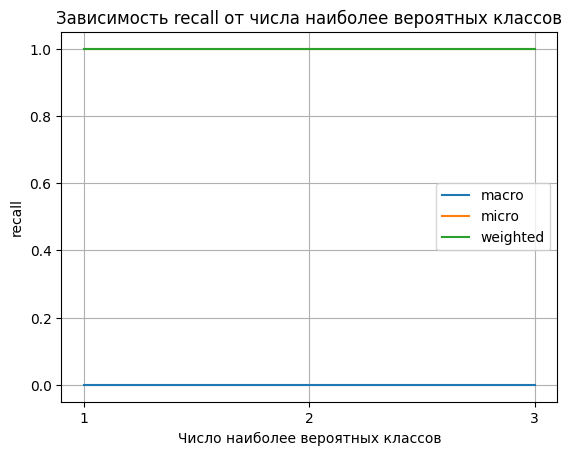

In [45]:
test_predictons_v2(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 246, 
                   level=2, grnti_path="grnti_dicts_level2/")

### Train level 2 with labels correct

In [3]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [4]:
base_name = "results_5/"
number_of_delteted_values = 0
minimal_number_of_elements_RGNTI2 = 300
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level2_with_label/"

In [5]:
epoch= 8
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"
dir_name = base_name + f"model bert lora level 2 with labels/"

Удаление элементов второго уровня, количство которых меньше 300
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружен

100%|██████████| 47/47 [00:28<00:00,  1.64it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9528220888159016


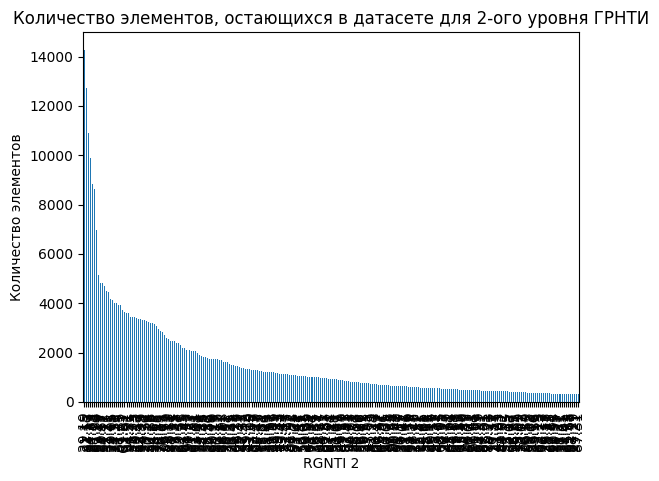

In [6]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_2_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder = "grnti_dicts_level2/")

In [7]:
df = prepair_data_level2(df, df["target_coded"],
                         path_to_grnti_model_codes="grnti_dicts_level2/")

Подготовка данных 2 уровень


100%|██████████| 279659/279659 [00:00<00:00, 575512.41it/s]


Доля непредсказанных классов GRNTI 1 для статей: 0.0


In [8]:
df.shape

(279659, 13)

In [9]:
with open("trainer_predictions_level1.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [10]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [11]:
label_test = sigmoid_array(prediction1_experiment) >= 0.5

In [12]:
label_test.shape, df_test.shape

((166183, 36), (166183, 13))

In [13]:
df_test = prepair_data_level2(df_test, label_test, 
                              path_to_grnti_model_codes="grnti_dicts_level1/")

Подготовка данных 2 уровень


100%|██████████| 166183/166183 [00:07<00:00, 21931.58it/s]


Доля непредсказанных классов GRNTI 1 для статей: 0.0836848534446965


In [14]:
df_test.shape

(166183, 13)

In [15]:
df_test.head()['text']

0    Математика; Обратная задача для уравнения в ба...
1    Физика; Моделирование динамики безмассовых нос...
2    Металлургия; Градиентные дислокационные субстр...
3    Организация и управление; Особенности корпорат...
4    Биология; Оценка экстерьера коров герефордской...
Name: text, dtype: object

In [16]:
n_classes, n_classes2

(47, 246)

In [17]:
train_dataset, validation_dataset, test_dataset,\
tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                        n_classes2, 
                                                        level = '2',
                                                        max_number_tokens=max_number_tokens, 
                                                        pre_trained_model_name=pre_trained_model_name)

Веса для кажого класса:  tensor([0.3324, 0.3050, 1.0957, 1.0359, 1.6289, 0.9368, 0.6091, 1.0129, 0.8051,
        1.0997, 0.9416, 0.4420, 2.2994, 0.6026, 0.3403, 0.5159, 0.6951, 2.6470,
        0.8494, 3.0454, 1.1965, 3.6569, 3.1184, 2.4879, 0.6715, 1.6677, 2.5795,
        0.5499, 1.0763, 2.0101, 2.9092, 1.5381, 0.1151, 1.7578, 2.5722, 0.1291,
        1.8321, 0.9995, 0.1317, 1.5645, 0.3132, 2.1127, 0.9802, 0.8174, 0.3629,
        0.9263, 1.9089, 2.7181, 1.1037, 1.5076, 1.4161, 2.0012, 2.7262, 2.7262,
        0.3832, 2.3348, 2.8367, 1.1719, 1.4710, 1.9752, 1.1934, 1.2076, 0.8656,
        0.6532, 0.3139, 0.1045, 1.6202, 1.8583, 1.9752, 1.4408, 1.7784, 1.1159,
        1.1325, 3.4622, 3.5991, 3.1950, 0.2844, 0.3359, 0.3512, 2.3590, 1.6348,
        2.6703, 0.4615, 1.4976, 1.5355, 0.2724, 0.7789, 2.3590, 0.8486, 0.3538,
        1.1439, 2.5016, 0.8781, 0.7464, 0.3536, 1.3734, 2.4478, 0.2879, 0.5738,
        1.0254, 2.1836, 0.3379, 1.2612, 0.7776, 1.4927, 0.2423, 0.9226, 0.9397,
        0.5495,

Map:   0%|          | 0/223999 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/55660 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

In [18]:
len(train_dataset['label'][0])

246

In [19]:
len(class_weights)

246

In [20]:
model = prepair_model(n_classes=n_classes2, 
                      pre_trained_model_name=pre_trained_model_name,
                        r=r, lora_alpha=lora_alpha, 
                        lora_dropout=lora_dropout)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [21]:
model.to("cuda");

In [22]:
save_parameters(dir_name= dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [23]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes2)


In [24]:
training_args = TrainingArguments(
    output_dir=dir_name,          
    num_train_epochs=epoch,
    warmup_steps=warmup_steps,
    logging_dir=dir_name,
    weight_decay=weight_decay,
    eval_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = False,
    save_safetensors = False,
    fp16=fp16,
    optim = optim,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    group_by_length=True,#True,
    dataloader_num_workers  = 4

    )

In [25]:
train_dataset = train_dataset.remove_columns("text")
validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

In [26]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator = collate_fn,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [27]:
train_dataset, validation_dataset

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 223999
 }),
 Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 55660
 }))

In [28]:
trainer.train()

  0%|          | 0/224000 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6659, 'grad_norm': 0.41081011295318604, 'learning_rate': 4.9979909817402566e-05, 'epoch': 0.0}
{'loss': 0.0861, 'grad_norm': 0.1002080887556076, 'learning_rate': 4.9957587392294306e-05, 'epoch': 0.01}
{'loss': 0.0388, 'grad_norm': 0.0674361139535904, 'learning_rate': 4.993526496718603e-05, 'epoch': 0.01}
{'loss': 0.0314, 'grad_norm': 0.06868865340948105, 'learning_rate': 4.991294254207777e-05, 'epoch': 0.01}
{'loss': 0.0297, 'grad_norm': 0.05979033187031746, 'learning_rate': 4.989062011696951e-05, 'epoch': 0.02}
{'loss': 0.0282, 'grad_norm': 0.0658678412437439, 'learning_rate': 4.986829769186125e-05, 'epoch': 0.02}
{'loss': 0.0265, 'grad_norm': 0.0545731820166111, 'learning_rate': 4.9845975266752984e-05, 'epoch': 0.03}
{'loss': 0.027, 'grad_norm': 0.06960928440093994, 'learning_rate': 4.982365284164472e-05, 'epoch': 0.03}
{'loss': 0.0278, 'grad_norm': 0.6035258173942566, 'learning_rate': 4.980133041653646e-05, 'epoch': 0.03}
{'loss': 0.0267, 'grad_norm': 0.05920426547527313,

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.016913803294301033, 'eval_accuracy_micro_0.5': 0.9945135116577148, 'eval_accuracy_macro_0.5': 0.9945135116577148, 'eval_accuracy_weighted_0.5': 0.9864962697029114, 'eval_f1_micro_0.5': 0.09360408037900925, 'eval_f1_macro_0.5': 0.0119951656088233, 'eval_f1_weighted_0.5': 0.05748791992664337, 'eval_f1_micro_0.6': 0.04113908112049103, 'eval_f1_macro_0.6': 0.005829036235809326, 'eval_f1_weighted_0.6': 0.029636364430189133, 'eval_f1_micro_0.7': 0.007490441203117371, 'eval_f1_macro_0.7': 0.0012250276049599051, 'eval_f1_weighted_0.7': 0.006778382696211338, 'eval_f1_micro_0.8': 5.245763895800337e-05, 'eval_f1_macro_0.8': 0.0, 'eval_f1_weighted_0.8': 0.0, 'eval_f1_micro_0.9': 0.0, 'eval_aucroc_micro': 0.5905473828315735, 'eval_aucroc_macro': 0.5272362232208252, 'eval_aucroc_weighted': 0.5882762670516968, 'eval_runtime': 1272.1392, 'eval_samples_per_second': 43.753, 'eval_steps_per_second': 5.47, 'epoch': 1.0}
{'loss': 0.0182, 'grad_norm': 0.052448008209466934, 'learning_rate': 4

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.011305509135127068, 'eval_accuracy_micro_0.5': 0.995407223701477, 'eval_accuracy_macro_0.5': 0.9954072833061218, 'eval_accuracy_weighted_0.5': 0.9896353483200073, 'eval_f1_micro_0.5': 0.4032793641090393, 'eval_f1_macro_0.5': 0.17180883884429932, 'eval_f1_weighted_0.5': 0.3140001595020294, 'eval_f1_micro_0.6': 0.2911113500595093, 'eval_f1_macro_0.6': 0.11867200583219528, 'eval_f1_weighted_0.6': 0.21651919186115265, 'eval_f1_micro_0.7': 0.19283337891101837, 'eval_f1_macro_0.7': 0.07719235867261887, 'eval_f1_weighted_0.7': 0.14018574357032776, 'eval_f1_micro_0.8': 0.11159568279981613, 'eval_f1_macro_0.8': 0.016964824870228767, 'eval_f1_weighted_0.8': 0.026007162407040596, 'eval_f1_micro_0.9': 0.030958155170083046, 'eval_aucroc_micro': 0.7848713397979736, 'eval_aucroc_macro': 0.6869289875030518, 'eval_aucroc_weighted': 0.782199501991272, 'eval_runtime': 1237.2, 'eval_samples_per_second': 44.989, 'eval_steps_per_second': 5.624, 'epoch': 2.0}
{'loss': 0.0125, 'grad_norm': 0.0

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.009609829634428024, 'eval_accuracy_micro_0.5': 0.9959204792976379, 'eval_accuracy_macro_0.5': 0.9959205389022827, 'eval_accuracy_weighted_0.5': 0.9907562136650085, 'eval_f1_micro_0.5': 0.5168494582176208, 'eval_f1_macro_0.5': 0.28272655606269836, 'eval_f1_weighted_0.5': 0.43136459589004517, 'eval_f1_micro_0.6': 0.4314326345920563, 'eval_f1_macro_0.6': 0.21238018572330475, 'eval_f1_weighted_0.6': 0.3434235155582428, 'eval_f1_micro_0.7': 0.3330056369304657, 'eval_f1_macro_0.7': 0.15352267026901245, 'eval_f1_weighted_0.7': 0.2578818202018738, 'eval_f1_micro_0.8': 0.21305102109909058, 'eval_f1_macro_0.8': 0.04218664392828941, 'eval_f1_weighted_0.8': 0.07077865302562714, 'eval_f1_micro_0.9': 0.09238485991954803, 'eval_aucroc_micro': 0.8302618265151978, 'eval_aucroc_macro': 0.7521277666091919, 'eval_aucroc_weighted': 0.828414797782898, 'eval_runtime': 1323.233, 'eval_samples_per_second': 42.064, 'eval_steps_per_second': 5.258, 'epoch': 3.0}
{'loss': 0.0107, 'grad_norm': 0.028

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.008684004656970501, 'eval_accuracy_micro_0.5': 0.9963472485542297, 'eval_accuracy_macro_0.5': 0.9963472485542297, 'eval_accuracy_weighted_0.5': 0.9918860793113708, 'eval_f1_micro_0.5': 0.6048962473869324, 'eval_f1_macro_0.5': 0.4003407061100006, 'eval_f1_weighted_0.5': 0.5338156223297119, 'eval_f1_micro_0.6': 0.5442902445793152, 'eval_f1_macro_0.6': 0.3223845660686493, 'eval_f1_weighted_0.6': 0.4650766849517822, 'eval_f1_micro_0.7': 0.45269280672073364, 'eval_f1_macro_0.7': 0.2467614710330963, 'eval_f1_weighted_0.7': 0.37389129400253296, 'eval_f1_micro_0.8': 0.3266761600971222, 'eval_f1_macro_0.8': 0.08793272078037262, 'eval_f1_weighted_0.8': 0.12739047408103943, 'eval_f1_micro_0.9': 0.1634194552898407, 'eval_aucroc_micro': 0.8662151098251343, 'eval_aucroc_macro': 0.8082073926925659, 'eval_aucroc_weighted': 0.8646414279937744, 'eval_runtime': 1210.3259, 'eval_samples_per_second': 45.988, 'eval_steps_per_second': 5.749, 'epoch': 4.0}
{'loss': 0.0106, 'grad_norm': 0.05102

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.008031605742871761, 'eval_accuracy_micro_0.5': 0.996601402759552, 'eval_accuracy_macro_0.5': 0.996601402759552, 'eval_accuracy_weighted_0.5': 0.9923896789550781, 'eval_f1_micro_0.5': 0.6404759287834167, 'eval_f1_macro_0.5': 0.4662763774394989, 'eval_f1_weighted_0.5': 0.5792669057846069, 'eval_f1_micro_0.6': 0.5833070874214172, 'eval_f1_macro_0.6': 0.38628602027893066, 'eval_f1_weighted_0.6': 0.5115933418273926, 'eval_f1_micro_0.7': 0.4960094690322876, 'eval_f1_macro_0.7': 0.2974882125854492, 'eval_f1_weighted_0.7': 0.41945308446884155, 'eval_f1_micro_0.8': 0.37476494908332825, 'eval_f1_macro_0.8': 0.11505811661481857, 'eval_f1_weighted_0.8': 0.16304871439933777, 'eval_f1_micro_0.9': 0.20484045147895813, 'eval_aucroc_micro': 0.8828074336051941, 'eval_aucroc_macro': 0.8333941102027893, 'eval_aucroc_weighted': 0.8814083337783813, 'eval_runtime': 1156.7656, 'eval_samples_per_second': 48.117, 'eval_steps_per_second': 6.015, 'epoch': 5.0}
{'loss': 0.0097, 'grad_norm': 0.04550

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.007788680959492922, 'eval_accuracy_micro_0.5': 0.9967963695526123, 'eval_accuracy_macro_0.5': 0.9967963695526123, 'eval_accuracy_weighted_0.5': 0.992914617061615, 'eval_f1_micro_0.5': 0.6790467500686646, 'eval_f1_macro_0.5': 0.5331941843032837, 'eval_f1_weighted_0.5': 0.6303656697273254, 'eval_f1_micro_0.6': 0.6385793685913086, 'eval_f1_macro_0.6': 0.4677237570285797, 'eval_f1_weighted_0.6': 0.5783723592758179, 'eval_f1_micro_0.7': 0.5614964962005615, 'eval_f1_macro_0.7': 0.3798506259918213, 'eval_f1_weighted_0.7': 0.49366962909698486, 'eval_f1_micro_0.8': 0.44338834285736084, 'eval_f1_macro_0.8': 0.16008132696151733, 'eval_f1_weighted_0.8': 0.21654903888702393, 'eval_f1_micro_0.9': 0.27153465151786804, 'eval_aucroc_micro': 0.9041957855224609, 'eval_aucroc_macro': 0.8648532032966614, 'eval_aucroc_weighted': 0.9028401970863342, 'eval_runtime': 1185.462, 'eval_samples_per_second': 46.952, 'eval_steps_per_second': 5.869, 'epoch': 6.0}
{'loss': 0.0094, 'grad_norm': 0.061054

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.007446466479450464, 'eval_accuracy_micro_0.5': 0.9968817830085754, 'eval_accuracy_macro_0.5': 0.9968817830085754, 'eval_accuracy_weighted_0.5': 0.9930854439735413, 'eval_f1_micro_0.5': 0.6857399344444275, 'eval_f1_macro_0.5': 0.5396745204925537, 'eval_f1_weighted_0.5': 0.6386964917182922, 'eval_f1_micro_0.6': 0.6438753008842468, 'eval_f1_macro_0.6': 0.47435781359672546, 'eval_f1_weighted_0.6': 0.5849581956863403, 'eval_f1_micro_0.7': 0.567261815071106, 'eval_f1_macro_0.7': 0.3873003125190735, 'eval_f1_weighted_0.7': 0.5005350112915039, 'eval_f1_micro_0.8': 0.4476804733276367, 'eval_f1_macro_0.8': 0.16469603776931763, 'eval_f1_weighted_0.8': 0.21984681487083435, 'eval_f1_micro_0.9': 0.2736380398273468, 'eval_aucroc_micro': 0.9036518335342407, 'eval_aucroc_macro': 0.8634545803070068, 'eval_aucroc_weighted': 0.9023680686950684, 'eval_runtime': 1254.1751, 'eval_samples_per_second': 44.38, 'eval_steps_per_second': 5.548, 'epoch': 7.0}
{'loss': 0.0086, 'grad_norm': 0.06917729

  0%|          | 0/6958 [00:00<?, ?it/s]

{'eval_loss': 0.00735237542539835, 'eval_accuracy_micro_0.5': 0.9969035387039185, 'eval_accuracy_macro_0.5': 0.9969035387039185, 'eval_accuracy_weighted_0.5': 0.9931420087814331, 'eval_f1_micro_0.5': 0.6888951063156128, 'eval_f1_macro_0.5': 0.5453199148178101, 'eval_f1_weighted_0.5': 0.6423501968383789, 'eval_f1_micro_0.6': 0.648240327835083, 'eval_f1_macro_0.6': 0.4798147678375244, 'eval_f1_weighted_0.6': 0.5895856022834778, 'eval_f1_micro_0.7': 0.5736028552055359, 'eval_f1_macro_0.7': 0.3933244049549103, 'eval_f1_weighted_0.7': 0.5062516927719116, 'eval_f1_micro_0.8': 0.4567797780036926, 'eval_f1_macro_0.8': 0.16927236318588257, 'eval_f1_weighted_0.8': 0.22580212354660034, 'eval_f1_micro_0.9': 0.28065580129623413, 'eval_aucroc_micro': 0.9043245911598206, 'eval_aucroc_macro': 0.8650913238525391, 'eval_aucroc_weighted': 0.9030715227127075, 'eval_runtime': 1249.2201, 'eval_samples_per_second': 44.556, 'eval_steps_per_second': 5.57, 'epoch': 8.0}
{'train_runtime': 56165.2671, 'train_samp

TrainOutput(global_step=224000, training_loss=0.012456665301695466, metrics={'train_runtime': 56165.2671, 'train_samples_per_second': 31.906, 'train_steps_per_second': 3.988, 'total_flos': 2.0491807243665766e+17, 'train_loss': 0.012456665301695466, 'epoch': 8.0})

In [29]:
trainer.model.save_pretrained("bert_peft_level2_with_labels")

In [30]:
trainer.save_model("bert_peft_level2_with_labels_v2")

### Test level 2 with labels 

In [31]:
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [32]:
predict_res = trainer.predict(test_dataset=test_dataset).predictions


  0%|          | 0/20773 [00:00<?, ?it/s]

In [33]:
torch.save("trainer_predictions_level2_with_labels.pt")

TypeError: save() missing 1 required positional argument: 'f'

In [34]:
with open("trainer_predictions_level2_with_labels.npy", 'wb') as f:
    np.save(f, predict_res)

In [35]:
with open("trainer_predictions_level2_with_labels.npy", 'rb') as f:

    prediction1_experiment = np.load(f)

In [36]:
predict_res

array([[ -6.7539062 ,  -8.0234375 ,  -9.5234375 , ...,  -9.8125    ,
         -8.484375  ,  -5.3398438 ],
       [ -3.0039062 , -11.140625  , -12.15625   , ..., -13.4609375 ,
        -13.3125    ,   0.76171875],
       [ -7.046875  , -10.1953125 , -11.6015625 , ..., -13.328125  ,
        -12.640625  ,  -1.7441406 ],
       ...,
       [ -8.609375  ,  -4.265625  ,  -9.59375   , ...,  -8.828125  ,
        -11.65625   ,  -7.9375    ],
       [ -6.6796875 , -10.640625  , -14.0234375 , ..., -16.515625  ,
        -17.359375  ,  -3.78125   ],
       [ -7.015625  , -10.1171875 , -11.1953125 , ..., -11.03125   ,
        -13.59375   ,  -9.390625  ]], dtype=float32)

In [37]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [38]:
label_test = np.vstack(df_test["target_coded2"])

In [39]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm2
import json
import torch
from peft import TaskType, LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification,\
    AutoTokenizer, DataCollatorWithPadding, Trainer
from collections import Counter
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
from datasets import Dataset
from TrainSettings import TrainSettings

from ignite.metrics import ClassificationReport
from ignite.engine.engine import Engine

from ignite.metrics.precision import Precision
from ignite.metrics.recall import Recall
from ignite.metrics.metrics_lambda import MetricsLambda

100%|██████████| 18/18 [06:44<00:00, 22.46s/it]


Cтатистика количества пркдсказываемых классов при заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1.6306)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(1)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(9)
Доля статей без предсказанного класса: 0.12718509113447218
recall_micro_list threshold: [tensor(0.6976), tensor(0.6567), tensor(0.6218), tensor(0.5900), tensor(0.5606), tensor(0.5322), tensor(0.5045), tensor(0.4765), tensor(0.4478), tensor(0.4180), tensor(0.3848), tensor(0.3479), tensor(0.3069), tensor(0.2618), tensor(0.2131), tensor(0.1625), tensor(0.1118), tensor(0.0508)]
recall_macro_list threshold: [tensor(0.6165), tensor(0.5679), tensor(0.5268), tensor(0.4886), tensor(0.4538), tensor(0.4227), tensor(0.3927), tensor(0.3628), tensor(0.3331), tensor(0.3039), tensor(0.2728), tensor(0.2411), tensor(0.2087), t

100%|██████████| 18/18 [00:03<00:00,  4.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 3/3 [01:22<00:00, 27.63s/it]


Cтатистика количества пркдсказываемых классов при не заданном threshold:
Среднее число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246.0000)
Минимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246)
Максимальное число предсказываемых классов для одной статьи, для которой получено предсказание tensor(246)
Доля статей без предсказанного класса: 0.0
f1_top_k_macro [0.64 0.53 0.43]
f1_top_k_maicro [0.73 0.57 0.46]
f1_top_k_weighted [0.75 0.6  0.5 ]
precision_top_k_macro [0.52 0.38 0.29]
precision_top_k_maicro [0.57 0.4  0.3 ]
precision_top_k_weighted [0.61 0.44 0.35]
recall_top_k_macro: tensor([0.9065, 0.9756, 0.9837])
recall_top_k_micro: tensor([1., 1., 1.])
recall_top_k_weighted: tensor([1., 1., 1.])


c:\Users\victo\git_Work_VINITI_2024\src\train.py:1055: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(test_dataset_labels).int()


<Figure size 640x480 with 0 Axes>

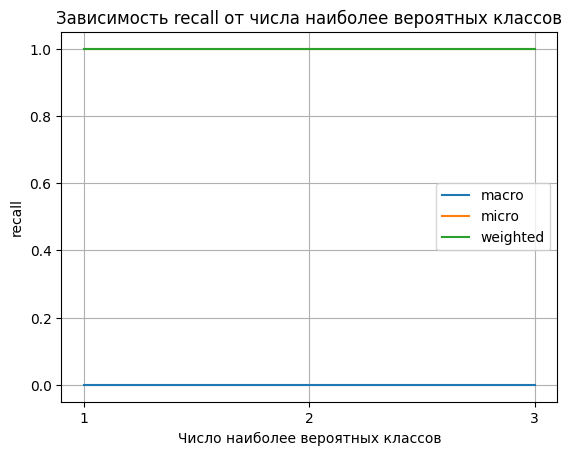

In [40]:
test_predictons(sigmoid_array(prediction1_experiment), label_test, path_info_before_save, 246, 
                   level=2, grnti_path="grnti_dicts_level2/")